**Research Skills: Spatiotemporal Data Analyis**

**Take-home Assignment** 

Sharon Ong, Department of Cognitive Science and Artificial Intelligence, Tilburg University Academic Year 2022-2023

**Sources**   

https://pysal.org/esda/notebooks/spatialautocorrelation.html

# Packages

In [ ]:
COLAB = False
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Load the contents of the directory
    !ls

    # Change your working directory to the folder where you stored your files, e.g.
    %cd /content/drive/My Drive/Colab Notebooks/STDA

import itertools
from os.path import join
import splot
import spreg
from splot import esda as esdaplot


import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error
from splot.esda import moran_scatterplot
import datetime as datetime

import pandas as pd
import geopandas as gpd
import mapclassify
import scipy.signal

%matplotlib inline

import seaborn as sns
import contextily as ctx
import pointpats

from pysal.lib import weights
from pysal.explore import esda
import contextily
from matplotlib import colors
import warnings
warnings.filterwarnings("ignore")

from splot.esda import plot_local_autocorrelation
from matplotlib import colors

# Part 2
## Predicting the average income in the Netherlands with spatial autoregression
1. [5 points] Load the dataset. Create histogram plots of the latitude, longitude, average income, average house price and population density (the data in the columns LATITUDE,LONGITUDE, Population Density, Average House Price, Average Income). Is each feature normally distributed?

Points breakdown: 3 points for the histogram plot. 2 points for answering the question.

In [41]:
gemeenten = pd.read_csv("Gemeenten_dataset.csv")
gemeenten.head()

,GM_CODE,GM_NAAM,ELEVATION,LATITUDE,LONGITUDE,Average_House_Price,Average_Income,Population_Density
0,GM0003,Appingedam,0.48,53.32,6.85,194.8,21.6,493
1,GM0010,Delfzijl,2.03,53.33,6.92,155.1,22.0,186
2,GM0014,Groningen,14.02,53.22,6.55,258.9,23.3,1257
3,GM0024,Loppersum,2.00,53.33,6.75,192.4,22.6,192
4,GM0034,Almere,1.92,52.37,5.22,294.3,24.7,1662


((array([221.,  62.,  30.,  17.,   6.,  11.,   3.,   2.,   2.,   1.]),
  array([  23. ,  685.7, 1348.4, 2011.1, 2673.8, 3336.5, 3999.2, 4661.9,
         5324.6, 5987.3, 6650. ]),
  <BarContainer object of 10 artists>),
 Text(0.5, 1.0, 'Histogram of Population Density'),
 None)

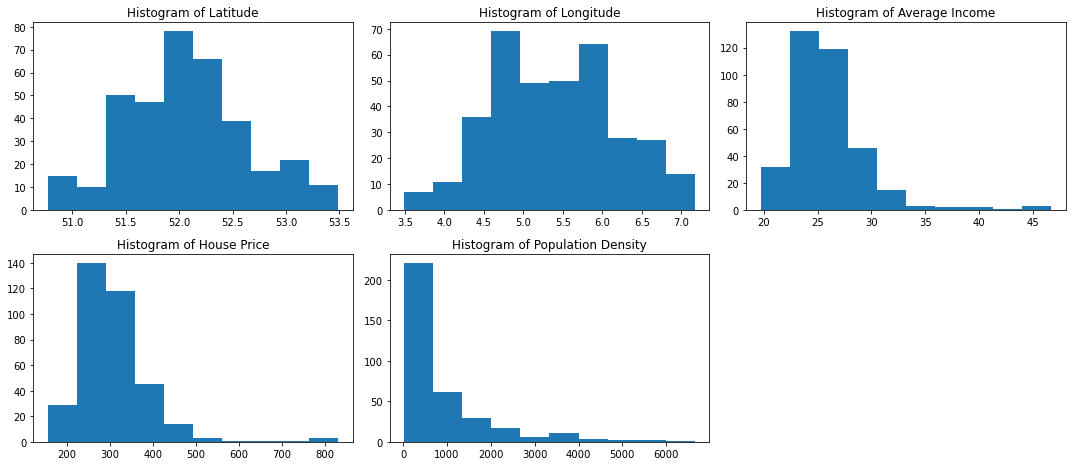

In [42]:
plt.figure(figsize = (15, 16))
plt.subplot(531)
plt.hist(gemeenten["LATITUDE"]), plt.title("Histogram of Latitude"), plt.tight_layout(), 
plt.subplot(532)
plt.hist(gemeenten["LONGITUDE"]), plt.title("Histogram of Longitude"), plt.tight_layout()
plt.subplot(533)
plt.hist(gemeenten["Average_Income"]), plt.title("Histogram of Average Income"), plt.tight_layout()
plt.subplot(534)
plt.hist(gemeenten["Average_House_Price"]), plt.title("Histogram of House Price"), plt.tight_layout()
plt.subplot(535)
plt.hist(gemeenten["Population_Density"]), plt.title("Histogram of Population Density"), plt.tight_layout()

**`histogram explanation`**

The histogram shows that only the latitude and the longitude data have roughly normal distribution. The average income, the average house price and the population density contain outliers and are right skewed, so not normally distributed.

2. [3 points] Display the latitude and longitude in a dot density map with a dot size corresponding to average income (the data in the column Average Income). 
For full points, the dot size shoud correspoind to the average income. 

Text(0.5, 1.0, 'Average Income per City')

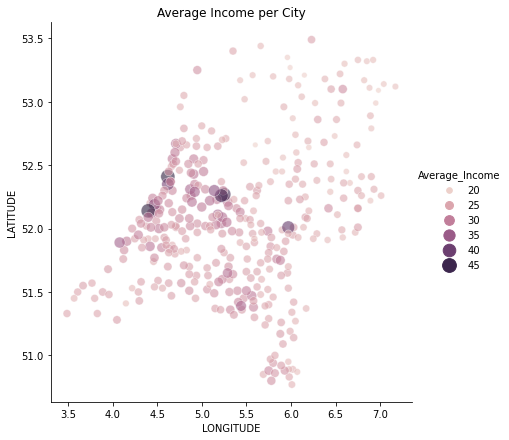

In [43]:
sns.relplot(x="LONGITUDE", y="LATITUDE",size="Average_Income",hue = "Average_Income",color = "0.9",
            sizes=(30, 200), alpha=0.6, kind = 'scatter',
            height=6, data=gemeenten)
plt.title("Average Income per City")

3. [10 points] Using distance based weighting schemes and KNN based weighing schemes, compute and compare the global autocorrelation (Global Moran's I) of Average Income and the log transformation of the Average Income. Try at least two distance values and 2 different K number of neighbours. Which feature (Average Income or its log transformation) has a higher autocorrelation?

Points breakdown: For each feature, 1 points for computing the global autocorrelation and 1.5 points for trying different distance values or settings (setting binary to True or False), 1.5 points for trying different number of neighbours. 2 points for answering the question.

In [44]:
shapefile_towns = gpd.read_file(join('bu_wk_gm2020_shapes'))
no_water = shapefile_towns[shapefile_towns['WATER'] == 'NEE']
shapefile_towns_1 = no_water.copy()
df = gpd.GeoDataFrame(shapefile_towns_1.join(gemeenten[["Average_Income", "Average_House_Price", "Population_Density", 
                                                       "LATITUDE", "LONGITUDE"]]), crs= shapefile_towns_1.crs)
subset_df = df.loc[:, "GM_NAAM": "LONGITUDE"]

subset_df.crs

# calculate the logarithmic value of the average income
subset_df["Average_Income_log"] = np.log(subset_df["Average_Income"] + 0.0001)

d  = [] # create empty list for the knn paramaters and distance values

for k in [3, 6, 10]: # knn based values
    knn= weights.KNN.from_dataframe(subset_df, k=k)
    mknn = esda.moran.Moran(subset_df["Average_Income"], knn)
    m_logknn = esda.moran.Moran(subset_df["Average_Income_log"], knn)
    d.append((str(k)+" knn", mknn.I, mknn.p_sim, m_logknn.I, m_logknn.p_sim))
    
    

for distance in  [10000, 25000, 50000]: # distance based values
        w_db= weights.DistanceBand.from_dataframe(subset_df, distance, silence_warnings = True)
        dis = esda.Moran(subset_df["Average_Income"], w_db)
        dis_log =  esda.Moran(subset_df["Average_Income_log"], w_db)
        d.append((str(distance) +" distance", dis.I, dis.p_sim, dis_log.I, dis_log.p_sim))
        
# dataframe
df = pd.DataFrame(d, columns=('KNN/distance', 'Moran I',"P_value",  "Moran I (log form)", "P_value (log form)"))

df.set_index('KNN/distance').sort_values(by = "Moran I (log form)", ascending=False)

,Moran I,P_value,Moran I (log form),P_value (log form)
KNN/distance,,,,
3 knn,0.528894,0.001,0.578511,0.001
10000 distance,0.479549,0.001,0.526832,0.001
6 knn,0.453710,0.001,0.506476,0.001
10 knn,0.407093,0.001,0.459959,0.001
25000 distance,0.368305,0.001,0.426274,0.001
50000 distance,0.272290,0.001,0.320847,0.001


**`Interpretation`**

The p_value (p_sim) of all the chosen distance and knn values are significant, which means that we can reject the null hypothesis of no spatial autocorrelation. For the knn and the distance values, the log transformation of the average income has higher global autocorrelation than the average income. The parameter with the highest autocorrelation is log knn of 3, the autocorrelation of 0.58. 

4. [10 points] Compute the local autocorrelation for the same two features. **Choose the weighting scheme and parameters** which gave you the highest correlation in 3.3. Identify the **'hotspots'** by display the hotspots as these townships with different **colors in a scatter plot**.

Points breakdown: 2 points for computing local autocorrelation and 3 points for displaying the hotspots for Average Income. 2 points for computing local autocorrelation and 3 points for displaying the hotspots for the log transformation of Average Income.

Text(0.5, 1.0, 'Hotspots for log Average Income \n (KNN = 3)')

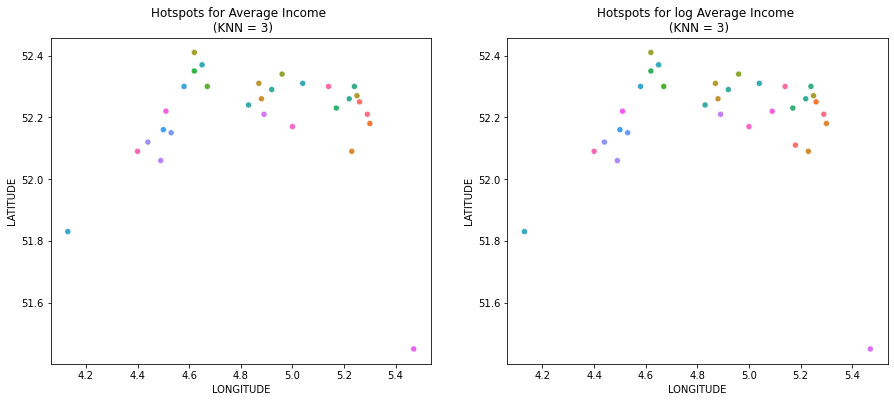

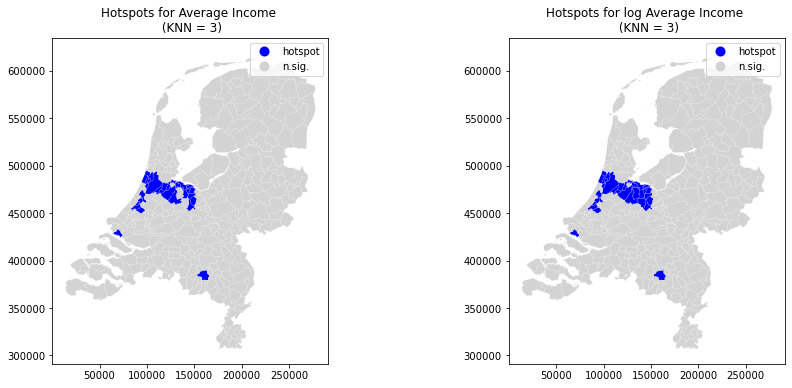

In [45]:
# calculate the local autocorrelation of the average income based on knn 3
knn3= weights.KNN.from_dataframe(subset_df, k=3)
knn3.transform = 'r'
local_knn = esda.Moran_Local(subset_df["Average_Income"].values, knn3)

# calculate the p value based on Moran's I local 
p_sim = local_knn.p_sim < 0.05

# extract the hotspot quadrant (1)
hotspot = p_sim * local_knn.q==1

# create binary label based on hotspots and not hotspots
spots = ['n.sig.', 'hotspot']
labels = [spots[i] for i in hotspot*1]

# include hotspots label into the dataframe
df = subset_df
hotspot_avg= df.assign(cl = labels)
hotspot_avg = hotspot_avg[hotspot_avg["cl"] == "hotspot"]


# calculate the local autocorrelation of the log average income based on knn3
local_knn_log = esda.Moran_Local(subset_df["Average_Income_log"].values, knn3)

# Select significant areas/cities
p_sim1_log = local_knn_log.p_sim < 0.05


# extract the hotspots quadrant (1)
hotspot_log = p_sim1_log * local_knn_log.q==1

# create binary label based on hotspots and not hotspots
spots = ['n.sig.', 'hotspot']
labels_log = [spots[i] for i in hotspot_log*1]


# display the scatterplot of the hotspots both the normal average income and its a log form
df1 = subset_df
hotspot_log= df1.assign(cl = labels_log)
hotspot_log = hotspot_log[hotspot_log["cl"] == "hotspot"]

plt.figure(figsize = (15, 6))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="LONGITUDE", y="LATITUDE", data = hotspot_avg, hue = "GM_NAAM", ax= ax, legend= False)
plt.title('Hotspots for Average Income \n (KNN = 3)')


ax = plt.subplot(1,2,2)
sns.scatterplot(x="LONGITUDE", y="LATITUDE", data = hotspot_log, hue = "GM_NAAM", ax= ax, legend = False);
plt.title('Hotspots for log Average Income \n (KNN = 3)')



# display the hotspots on map a form
hmap = colors.ListedColormap(['blue', 'lightgrey'])
plt.figure(figsize = (15, 6))
ax = plt.subplot(1,2,1)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax = ax,\
        edgecolor='white', legend=True)
plt.title('Hotspots for Average Income \n (KNN = 3)')


ax = plt.subplot(1,2,2)
df1.assign(cl=labels_log).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax = ax,\
        edgecolor='white', legend=True)
plt.title('Hotspots for log Average Income \n (KNN = 3)')

Text(0.5, 1.0, 'Hotspots for log Average Income \n (distance of 10000)')

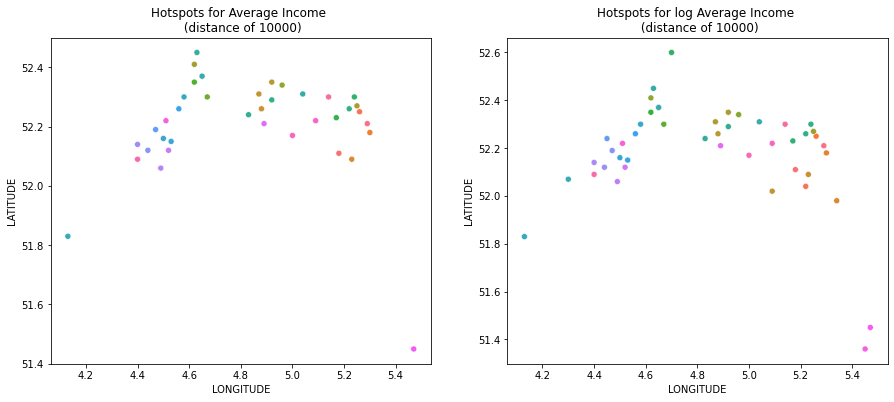

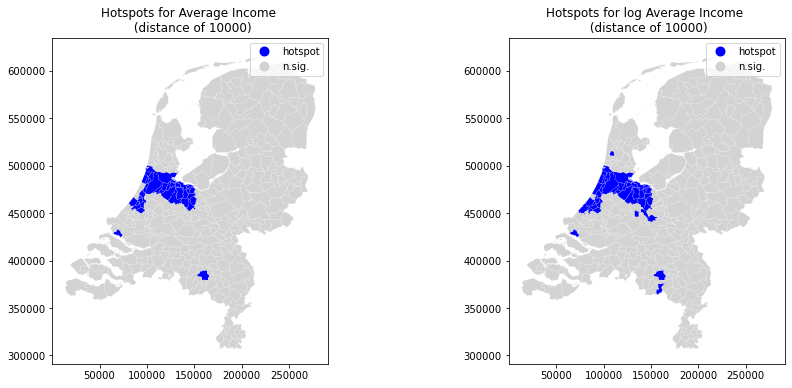

In [46]:
# local autocorrelation distance based (distance of 10000)
w_dis10000= weights.DistanceBand.from_dataframe(subset_df, 10000, silence_warnings = True)
w_dis10000.transform = "r"


# Calculate the Moran's Local
local_dis = esda.Moran_Local(subset_df["Average_Income"].values, w_dis10000)


# extract the significant areas
p_sim = local_dis.p_sim < 0.05

hotspot = p_sim * local_dis.q==1


# create hotspot labels
spots = ['n.sig.', 'hotspot']
labels = [spots[i] for i in hotspot*1]


df = subset_df
hotspot_avg= df.assign(cl = labels)
hotspot_avg = hotspot_avg[hotspot_avg["cl"] == "hotspot"]

# local autocorrelation distance based (distance of 10000, log form)
local_dis_log = esda.Moran_Local(subset_df["Average_Income_log"].values, w_dis10000)

# Extract significant areas
p_sim1_log = local_dis_log.p_sim < 0.05

# extract quadrant 1
hotspot_log = p_sim1_log * local_dis_log.q==1


spots = ['n.sig.', 'hotspot']
labels_log = [spots[i] for i in hotspot_log*1]


# hotspots scatterplot
df1 = subset_df
hotspot_log= df1.assign(cl = labels_log)
hotspot_log = hotspot_log[hotspot_log["cl"] == "hotspot"]

plt.figure(figsize = (15, 6))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="LONGITUDE", y="LATITUDE", data = hotspot_avg, hue = "GM_NAAM", ax= ax, legend=False)
plt.title('Hotspots for Average Income \n (distance of 10000)')

ax = plt.subplot(1,2,2)
sns.scatterplot(x="LONGITUDE", y="LATITUDE", data = hotspot_log, hue = "GM_NAAM", ax= ax, legend = False);
plt.title('Hotspots for log Average Income \n (distance of 10000)')


# hotspots map form
hmap = colors.ListedColormap(['blue', 'lightgrey'])
plt.figure(figsize = (15, 6))
ax = plt.subplot(1,2,1)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax = ax,\
        edgecolor='white', legend=True)

plt.title('Hotspots for Average Income \n (distance of 10000)')


ax = plt.subplot(1,2,2)
df1.assign(cl=labels_log).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax = ax,\
        edgecolor='white', legend=True)

plt.title('Hotspots for log Average Income \n (distance of 10000)')

5. (2 points) Perform a log transformation of the Population Density, Average House Price and Average Income.

In [47]:
subset_df["Average_Income_log"] = np.log(subset_df["Average_Income"] + 0.0001)
subset_df["Average_House_Price_log"] = np.log(subset_df["Average_House_Price"] + 0.0001)
subset_df["Population_Density_log"] = np.log(subset_df["Population_Density"] + 0.0001)
subset_df.head(3)

,GM_NAAM,geometry,Average_Income,Average_House_Price,Population_Density,LATITUDE,LONGITUDE,Average_Income_log,Average_House_Price_log,Population_Density_log
0,Appingedam,"POLYGON ((249539.950 593217.579, 249543.450 59...",21.6,194.8,493,53.32,6.85,3.072698,5.271974,6.200509
1,Delfzijl,"MULTIPOLYGON (((267829.905 587996.480, 267824....",22.0,155.1,186,53.33,6.92,3.091047,5.044071,5.225747
2,Groningen,"POLYGON ((227979.943 584879.819, 227981.153 58...",23.3,258.9,1257,53.22,6.55,3.148458,5.556442,7.136483


6. [10 points] Your goal is to compare predictions of **average income** (log values) per township based on the explanatory variables (**the average house price and population density**) as well as the spatially lagged average house price (exogenous regressor) and the spatially lagged average income (endogenous regressor). Please use the log form of the variables from of Question 5 for this question. Please use the \spreg" package for this task and the **weighting scheme** you selected in Question 4. Perform the following for a maximum of 10 points: 


(a) Fit a baseline linear regression model, where your target variable is the average income (the column Average Income) and your features (exploratory variables) are the columns Population Density and Average House Price. [2 points]

(b) One of the spatially lag variables that we think may affect the average income is the average house price. Using a weighting scheme of your choice, assigned (create) a spatial lag based on the average house price. Run the model, which has the same setup as in (a), with the exception that it includes this spatial lag. [2 points].  

(c) Using "GM Lag", run a spatial autoregression model with the lag of Average Income and the features in (a).[2 points]

(d) Using "GM Lag", run a spatial autoregression model with the lag of Average Income with the Population Density, Average House Price and the spatial lag of the Average House Price. (The features used in (b)). [2 points]

(e) Compute the **mean square error**  for the regressors in (a), (b), (c) and (d). Which regressor model resulted in the lowest mean square error? [2 points]

In [48]:
# 6.a
y  = subset_df["Average_Income_log"]
variable_names = ['Average_House_Price_log', 'Population_Density_log']

m1 = spreg.OLS(y.values, subset_df[variable_names].values, name_y= "Average_Income_log", name_x = variable_names)


# 6.b
knn3 = weights.KNN.from_dataframe(subset_df, k=3)
knn3.transform = "r"
subset_df["w_house_price"] = weights.lag_spatial(knn3, subset_df['Average_House_Price_log'].values)

extended_variable_names = variable_names + ["w_house_price"]

m2 = spreg.OLS(y.values, subset_df[extended_variable_names].values, 
               name_y = 'log_average_income', name_x = extended_variable_names)


# 6.c
knn1 = weights.KNN.from_dataframe(subset_df, k=1)
knn1.transform = "r"
m3 = spreg.GM_Lag(y.values, subset_df[variable_names].values, w=knn1,name_y = 'Average_Income_log', name_x = variable_names)

# 6.d
m4 = spreg.GM_Lag(y.values, subset_df[extended_variable_names].values, w=w_db,
               name_y = 'log_average_income', name_x = extended_variable_names)



# 6.e
mse = pd.Series({'m1(OLS)': mean_squared_error(y.values, m1.predy.flatten()),
                  'm2 (OLS+w_house_price)': mean_squared_error(y.values, m2.predy.flatten()),
                  'm3 (Lag)':mean_squared_error(y.values, m3.predy.flatten()), 
                "m4 (Lag + w_house_price)": mean_squared_error(y.values, m4.predy.flatten())})

print("The best perfoming model is: m4 (Lag + w_house_price):","MSE score:", round(mse.sort_values()[0], 4))
mse.sort_values()

The best perfoming model is: m4 (Lag + w_house_price): MSE score: 0.0036


m4 (Lag + w_house_price)    0.003601
m2 (OLS+w_house_price)      0.003754
m1(OLS)                     0.003840
m3 (Lag)                    0.003969
dtype: float64

 7. [10 points] Compare the performance of different spatial weighting matrices to predict the average income with the lag of Average Income and the features in Question 6(a). Please use the log form of
the variables from Question 5 for this question. Select 3 distance based weighting schemes, 3 KNN based
weighing schemes of your choice and run spatial autoregression models (with “GM Lag”). List your best
performing spatial weighting scheme (the one with lowest MSE).


Points breakdown: 3 points for implementing spatial autoregression with distance based weighting schemes, 3 points for implementing spatial autoregression with KNN based weighting schemes, 2 points for implementing spatial autoregression with a Queen contiguity weighting scheme and 2 points listing your best performing spatial weighting scheme (the one with lowest **MSE**).

In [49]:
variable_names = ['Average_House_Price_log', 'Population_Density_log']

# distance based models
for distance in [4000, 35000, 90000]:
    if distance == 4000:
        dis1 = weights.DistanceBand.from_dataframe(subset_df, distance, silence_warnings = True)
        m1 = spreg.GM_Lag(subset_df[["Average_Income_log"]].values, subset_df[variable_names].values, w = dis1, 
        name_y = "Average_Income_log", name_x = variable_names)
        
    if distance == 35000:
        dis2 = weights.DistanceBand.from_dataframe(subset_df, distance,silence_warnings = True)
        m2 = spreg.GM_Lag(subset_df[["Average_Income_log"]].values, subset_df[variable_names].values, w = dis2, 
        name_y = "Average_Income_log", name_x = variable_names)
        
    if distance == 90000:
        dis3 = weights.DistanceBand.from_dataframe(subset_df, distance,silence_warnings = True)
        m2 = spreg.GM_Lag(subset_df[["Average_Income_log"]].values, subset_df[variable_names].values, w = dis3, 
        name_y = "Average_Income_log", name_x = variable_names)


#knn based models
for knn in [9, 5, 11]:
    if knn == 9:
        knn1 = weights.KNN.from_dataframe(subset_df, k=knn)
        m4 = spreg.GM_Lag(subset_df[["Average_Income_log"]].values, subset_df[variable_names].values, w = knn1, 
        name_y = "Average_Income_log", name_x = variable_names)
    if knn == 5: 
        knn2= weights.KNN.from_dataframe(subset_df, k=knn)
        m5 = spreg.GM_Lag(subset_df[["Average_Income_log"]].values, subset_df[variable_names].values, w = knn2, 
        name_y = "Average_Income_log", name_x = variable_names)
    if knn == 11: 
        knn3 = weights.KNN.from_dataframe(subset_df, k=knn)
        m6 = spreg.GM_Lag(subset_df[["Average_Income_log"]].values, subset_df[variable_names].values, w = knn3, 
        name_y = "Average_Income_log", name_x = variable_names)
  
        

# queen based model
queen_weights = weights.Queen.from_dataframe(subset_df)
m7 = spreg.GM_Lag(subset_df[["Average_Income_log"]].values, subset_df[variable_names].values, w = queen_weights, 
                 name_y = "Average_Income_log", name_x = variable_names)



mse = pd.Series({'Distance_4000': mean_squared_error(y.values, m1.predy.flatten()),
                  'Distance_35000': mean_squared_error(y.values, m2.predy.flatten()),
                  'Distance_90000': mean_squared_error(y.values, m3.predy_e), 
                'KNN_9': mean_squared_error(y.values, m4.predy.flatten()), 
                'KNN_5': mean_squared_error(y.values, m5.predy.flatten()), 
               'KNN_11': mean_squared_error(y.values, m6.predy.flatten()), 
                'Queen': mean_squared_error(y.values, m7.predy.flatten())})

display(mse.sort_values())
print("The best perfoming model is: distance_35000:","MSE score:", round(mse.sort_values()[0], 4))

Distance_35000    0.003638
Queen             0.003806
Distance_90000    0.003823
Distance_4000     0.003835
KNN_11            0.003892
KNN_9             0.003949
KNN_5             0.004092
dtype: float64

The best perfoming model is: distance_35000: MSE score: 0.0036
